# Case Study 3 : Data Science in OpenAI Games

**Required Readings:** 
* [Deep Reinforcement Learning](http://karpathy.github.io/2016/05/31/rl/) 
* [OpenAI](https://gym.openai.com/)
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.

** NOTE **
* In this case study, you will need to use Mac OS or Linux system. In windows computers, you could use virtualbox to create a virtual machine and install an Ubuntu OS in the virtual machine.
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using OpenAI Games
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the openAI game system and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

We plan to solve the problem of automation and fitting into things. We plan to use the lunar lander in openAI games to solve this problem. The point of lunar lander is to try to get a spaceship to land on the moon perfectly between two flags. Using an AI you train the lander using only images and rewards to land perfectly between the two flags. This could be applied to several real world scenarios. The most obvious being having a NASA or SpaceX rocket land on some sort of moon or planet. This scenario could also apply to a self-driving car parking itself, an automated crane moving objects from one place to another, a plane landing, etc.

The AI for lunar lander does not know about any of the physics of the simulation, just the point values of an outcome after it occurs. However, over time the AI learns how the physics of the scenario work through trial in error. For all the examples above you would have to modify the game a little with different physics variables and scenarios to fit the goal. The AI will learn how the physics work over time and be able to complete the goal of fitting into things like how it does with the lunar lander game.

# Data Exploration: Exploring the OpenAI Game System (Gym)

**1. Playing Pacman** 
We first introduce an example of how to use the gym package from OpenAI to design an agent for Pacman Game.
In the following cell, we implemented a simple agent, which randomly picks the next action without looking at the screen image (i.e., the *observation*) or the reward.

Change the following code for **myAgent** to design a better agent, which takes the observation and reward as the input and picks the best action as the next move.
The agent should be able to improve itself after playing more games.

***The goals***: Implement an agent using neural networks that can achieve all the following goals:
* (a) move the PacMan in all directions.  (5 points)
* (b) using neural network to decide what is the best next move. (5 points)
* (c) after playing each episode of the game, the agent should be able to improve itself using the experience. (5 points)

Action Code:
* 1 - UP
* 2 - RIGHT
* 3 - LEFT
* 4 - DOWN

In [1]:
# This library has a dependency that does not work on Windows. Therefore, I'm going to provide the example code (CS 4445).

"""
Trains an agent with (stochastic) Policy Gradients on PacMan. Uses OpenAI Gym.
"""

import numpy as np
import cPickle as pickle
import gym

# Training parameters
episode_count = 200

# Data aggregation parameters
average_rewards = []
current_rewards = []

# Hyperparameters
H = 200 # Number of hidden layer neurons
batch_size = 10 # Episode interval to update parameters
learning_rate = 1e-4 # Rate to learn
gamma = 0.99 # Discount factor for reward
decay_rate = 0.99 # Decay factor for RMSProp leaky sum of grad^2
resume = False # Resume from previous checkpoint?
render = False # Whether to render the game. You should turn this off to speed up the program.

# Model initialization
D = 80 * 80 # Input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() } # Update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.iteritems() } # RMSProp memory

def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) # Sigmoid "squashing" function to interval [0,1]


def prepro(I):
    """
    Prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector
    """
    # crop the screen
    I = np.reshape(I[0:160], (160,160,3))
    I = I[:,:,1]
    I[I==111]=0
    I[I==28]=1
    I[I>1]=2
    I=I[::2,::2]
    return I.astype(np.float).ravel()


def discount_rewards(r):
    """
    Take 1D float array of rewards and compute discounted reward
    """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        if r[t] != 0: running_add = 0 # Reset the sum, since this was a game boundary
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # Return probability of taking action 2, and hidden state


def policy_backward(eph, epdlogp):
    """
    Backward pass. (eph is array of intermediate hidden states)
    """
    dW2 = np.dot(eph.T, epdlogp).ravel() # Ravel flaten the matrix into 1-d vector
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}


env = gym.make("MsPacman-v0")
observation = env.reset()
prev_x = None # Used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

while True:
    if render: env.render()

    # Preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # Forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)

    action = 2 
    y = .5
    
    if(np.random.uniform() < aprob/4):
        action = 1
        y=.25
    elif(np.random.uniform() < aprob/2):
        action = 2
        y = .5
    elif(np.random.uniform() < 3*aprob/4):
        action = 3
        y=.75
    else:
        action = 4
        y =1

    # Record various intermediates (needed later for backprop)
    xs.append(x) # Observation
    hs.append(h) # Hidden state
    # y = 1 if action == 2 else 0 # A "fake label"
    dlogps.append(y - aprob) # Grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # Step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    #print "reward:%f" % reward

    drs.append(reward) # Record reward (has to be done after we call step() to get reward for previous action)

    if done: # Episode finished
        episode_number += 1

        # Stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # Reset array memory

        # Compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # Standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # Modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

        # Perform RMSProp parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.iteritems():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # Boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        
        average_rewards.append(running_reward)
        current_rewards.append(reward_sum)
        
        print 'resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward)
        if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
    
    if episode_number >= episode_count:
        break

print 'Done training.'

[2017-04-05 16:16:48,139] Making new env: MsPacman-v0


resetting env. episode reward total was 250.000000. running mean: 250.000000
resetting env. episode reward total was 300.000000. running mean: 250.500000
resetting env. episode reward total was 240.000000. running mean: 250.395000
resetting env. episode reward total was 200.000000. running mean: 249.891050
resetting env. episode reward total was 230.000000. running mean: 249.692140
resetting env. episode reward total was 260.000000. running mean: 249.795218
resetting env. episode reward total was 240.000000. running mean: 249.697266
resetting env. episode reward total was 270.000000. running mean: 249.900293
resetting env. episode reward total was 240.000000. running mean: 249.801290
resetting env. episode reward total was 310.000000. running mean: 250.403277
resetting env. episode reward total was 260.000000. running mean: 250.499245
resetting env. episode reward total was 270.000000. running mean: 250.694252
resetting env. episode reward total was 310.000000. running mean: 251.287310

[2017-04-05 16:21:40,402] Making new env: MsPacman-v0


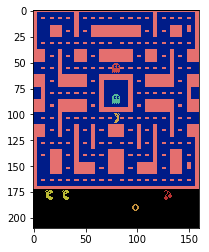

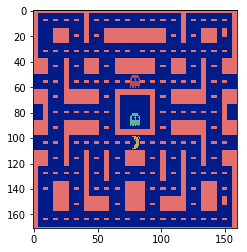

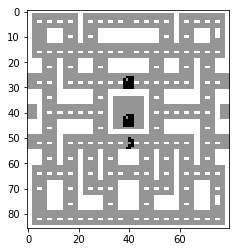

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

env=gym.make('MsPacman-v0')

observation = env.reset()
observation, reward, done, info = env.step(1)

# Plot the current screen
plt.figure(1)
plt.imshow(np.reshape(observation, (210,160,3) ))

# Crop the screen
x = np.reshape(observation[0:171], (171,160,3) )
plt.figure(2)
plt.imshow(x)

# Remove background
x = x[:,:,1]
x[x==111]=0
x[x==28]=1
x[x>1]=2

# Downsample
x=x[::2,::2]
plt.figure(3)
plt.imshow(x,cmap='Greys')

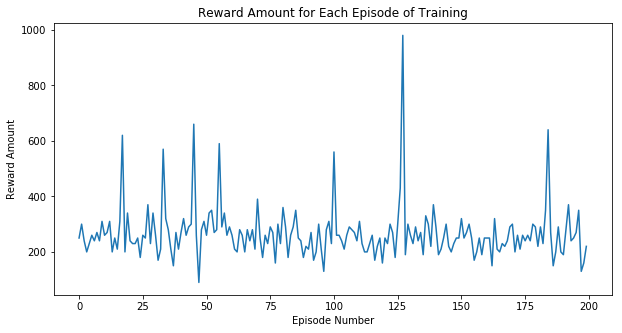

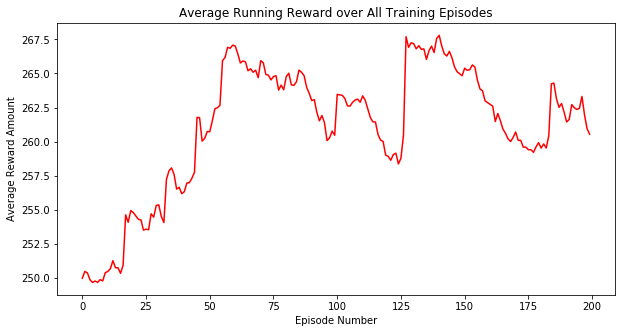

In [3]:
import matplotlib.pyplot as plt

# Graph reward for each episode over all training episodes
plt.figure(figsize=(10, 5))
plt.plot([x for x in range(0, len(current_rewards))], current_rewards)
plt.title("Reward Amount for Each Episode of Training")

ax = plt.gca()
ax.set_xlabel("Episode Number")
ax.set_ylabel("Reward Amount")

plt.show()

# Graph average running reward over all training episodes
plt.figure(figsize=(10, 5))
plt.plot([x for x in range(0, len(average_rewards))], average_rewards, color='r')
plt.title("Average Running Reward over All Training Episodes")

ax = plt.gca()
ax.set_xlabel("Episode Number")
ax.set_ylabel("Average Reward Amount")

plt.show()

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

We found a neural network that uses Covariance Matrix Adaptation Evolution Strategies from
this paper: https://arxiv.org/abs/1604.00772

The code was found on the OpenAI website.

According to the website the algorithm uses randomized optimization of non-linear and non-convex functions in order to train itself over time by using the images and rewards provided by the lunar lander game. The Neural Network figures out how to physics of the game works and how to park the lander after many thousands of iterations (~60000). The algorithm would be able to be adapted to scenarios above if a game was programmed to simulate those scenarios.

Write codes to implement the solution in python:

In [1]:
#This takes several hours to run

import logging
import os
import numpy as np

import gym
from gym import wrappers
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import TanhLayer
#from pybrain.structure.modules import LinearLayer
#from pybrain.structure.modules import ReluLayer
from pybrain.optimization import CMAES

#Buliding a simple neural network with 3 layers
def buildNet(n_input, n_output):
    # The algorithm also converges using linear and relu layer at the hidden or output unit.
    return buildNetwork(n_input,16, 12, n_output, hiddenclass=TanhLayer, outclass=TanhLayer, outputbias=False, recurrent=False)


def trainNetwork(env):
    # The training functions uses the average of the cumulated reward and maximum height as fitness
    def objF(params):
        nn = buildNet(len(env.observation_space.high), env.action_space.n)
        nn._setParameters(np.array(params))

        cum_reward = 0
        highest_count = []
        episode_count = 15
        max_steps = 1200

        for i in range(episode_count):
            highest = -1
            ob = env.reset()

            for j in range(max_steps):
                result = nn.activate(ob)
                action = np.argmax(result)
                ob, reward, done, _ = env.step(action)
                cum_reward += reward

                if highest < ob[0]:
                    highest = ob[0]

                if done:
                    break

            nn.reset()

        highest_count.append(highest)

        return (sum(highest_count) + cum_reward) / len(highest_count)
    
    # Build net for initial random params
    n = buildNet(len(env.observation_space.high), env.action_space.n)
    x0 = n.params

    l = CMAES(objF, x0, verbose=True)

    # Some arbitrary desired fitness value
    l.desiredEvaluation = -3600
    l.maxLearningSteps = 200
    l.mustMaximize
    l.minimize = False
    learned = l.learn()

    return learned


if __name__ == '__main__':
    # Initialization
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    env = gym.make('LunarLander-v2')
    print(env.observation_space)
    print(env.action_space)
    outdir = '/tmp/CMAES-LunarLander-results'
    env = gym.wrappers.Monitor(env, outdir, force=True)

    learned = trainNetwork(env)

    nn = buildNet(len(env.observation_space.high), env.action_space.n)
    nn._setParameters(np.array(learned[0]))
    env.close()
    # Test the trained network
    episode_count = 300
    max_steps = 1200

    for i in range(episode_count):
        ob = env.reset()

        for j in range(max_steps):
            result = nn.activate(ob)
            action = np.argmax(result)
            ob, reward, done, _ = env.step(action)
            if done:
                nn.reset()
                break


[2017-04-05 09:46:11,094] Making new env: LunarLander-v2
[2017-04-05 09:46:11,134] Creating monitor directory /tmp/CMAES-LunarLander-results
[2017-04-05 09:46:11,179] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000000.mp4


Box(8,)
Discrete(4)


[2017-04-05 09:46:13,012] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000001.mp4
[2017-04-05 09:46:15,074] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000008.mp4
[2017-04-05 09:46:16,819] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000027.mp4
[2017-04-05 09:46:18,808] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000064.mp4
[2017-04-05 09:46:21,794] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000125.mp4
[2017-04-05 09:46:25,196] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000216.mp4


Step: 0 best: 2959.32324064


[2017-04-05 09:46:30,382] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000343.mp4
[2017-04-05 09:46:36,276] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000512.mp4


Step: 1 best: 2959.32324064


[2017-04-05 09:46:41,271] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video000729.mp4


Step: 2 best: 2578.91718499


[2017-04-05 09:46:48,784] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video001000.mp4


Step: 3 best: 2446.60211706
Step: 4 best: 2446.60211706
Step: 5 best: 2348.66743977


[2017-04-05 09:47:03,923] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video002000.mp4


Step: 6 best: 2308.56876913
Step: 7 best: 2046.40520278
Step: 8 best: 2046.40520278


[2017-04-05 09:47:18,243] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video003000.mp4


Step: 9 best: 2046.40520278
Step: 10 best: 2046.40520278
Step: 11 best: 1606.3222983


[2017-04-05 09:47:31,020] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video004000.mp4


Step: 12 best: 1606.3222983
Step: 13 best: 1379.26216028
Step: 14 best: 1379.26216028


[2017-04-05 09:47:47,211] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video005000.mp4


Step: 15 best: 1379.26216028
Step: 16 best: 1379.26216028
Step: 17 best: 1379.26216028
Step: 18 best: 1379.26216028


[2017-04-05 09:48:03,013] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video006000.mp4


Step: 19 best: 1379.26216028
Step: 20 best: 1379.26216028
Step: 21 best: 1379.26216028


[2017-04-05 09:48:20,698] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video007000.mp4


Step: 22 best: 1379.26216028
Step: 23 best: 1379.26216028
Step: 24 best: 1379.26216028


[2017-04-05 09:48:38,362] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video008000.mp4


Step: 25 best: 1379.26216028
Step: 26 best: 1379.26216028
Step: 27 best: 1379.26216028


[2017-04-05 09:48:57,013] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video009000.mp4


Step: 28 best: 1379.26216028
Step: 29 best: 1379.26216028
Step: 30 best: 1379.26216028


[2017-04-05 09:49:14,330] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video010000.mp4


Step: 31 best: 1379.26216028
Step: 32 best: 1379.26216028
Step: 33 best: 1379.26216028


[2017-04-05 09:49:33,256] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video011000.mp4


Step: 34 best: 1379.26216028
Step: 35 best: 1379.26216028
Step: 36 best: 1379.26216028
Step: 37 best: 1379.26216028


[2017-04-05 09:49:52,530] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video012000.mp4


Step: 38 best: 1379.26216028
Step: 39 best: 1379.26216028
Step: 40 best: 1379.26216028


[2017-04-05 09:50:14,224] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video013000.mp4


Step: 41 best: 1379.26216028
Step: 42 best: 1265.09472769
Step: 43 best: 1265.09472769


[2017-04-05 09:50:33,781] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video014000.mp4


Step: 44 best: 1265.09472769
Step: 45 best: 1265.09472769
Step: 46 best: 1265.09472769


[2017-04-05 09:50:53,517] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video015000.mp4


Step: 47 best: 1265.09472769
Step: 48 best: 1265.09472769
Step: 49 best: 1265.09472769


[2017-04-05 09:51:12,875] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video016000.mp4


Step: 50 best: 1265.09472769
Step: 51 best: 1265.09472769
Step: 52 best: 1265.09472769


[2017-04-05 09:51:30,730] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video017000.mp4


Step: 53 best: 1265.09472769
Step: 54 best: 1265.09472769
Step: 55 best: 1265.09472769
Step: 56 best: 1265.09472769


[2017-04-05 09:51:49,349] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video018000.mp4


Step: 57 best: 1265.09472769
Step: 58 best: 1265.09472769
Step: 59 best: 1151.08163959


[2017-04-05 09:52:14,263] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video019000.mp4


Step: 60 best: 1151.08163959
Step: 61 best: 1151.08163959
Step: 62 best: 1151.08163959


[2017-04-05 09:52:32,315] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video020000.mp4


Step: 63 best: 1151.08163959
Step: 64 best: 1151.08163959
Step: 65 best: 1151.08163959


[2017-04-05 09:52:54,571] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video021000.mp4


Step: 66 best: 1151.08163959
Step: 67 best: 1151.08163959
Step: 68 best: 1151.08163959


[2017-04-05 09:53:17,471] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video022000.mp4


Step: 69 best: 296.331777915
Step: 70 best: 296.331777915
Step: 71 best: 296.331777915


[2017-04-05 09:53:38,776] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video023000.mp4


Step: 72 best: 296.331777915
Step: 73 best: 296.331777915
Step: 74 best: 296.331777915
Step: 75 best: 296.331777915


[2017-04-05 09:53:59,946] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video024000.mp4


Step: 76 best: 296.331777915
Step: 77 best: 296.331777915
Step: 78 best: 296.331777915


[2017-04-05 09:54:15,140] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video025000.mp4


Step: 79 best: 296.331777915
Step: 80 best: 296.331777915
Step: 81 best: 296.331777915


[2017-04-05 09:54:34,255] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video026000.mp4


Step: 82 best: 296.331777915
Step: 83 best: 296.331777915
Step: 84 best: 296.331777915


[2017-04-05 09:54:57,104] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video027000.mp4


Step: 85 best: 296.331777915
Step: 86 best: 296.331777915
Step: 87 best: 296.331777915


[2017-04-05 09:55:21,683] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video028000.mp4


Step: 88 best: 296.331777915
Step: 89 best: 296.331777915
Step: 90 best: 296.331777915
Step: 91 best: 296.331777915


[2017-04-05 09:55:47,722] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video029000.mp4


Step: 92 best: 296.331777915
Step: 93 best: 296.331777915
Step: 94 best: 296.331777915


[2017-04-05 09:56:13,289] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video030000.mp4


Step: 95 best: 296.331777915
Step: 96 best: 296.331777915
Step: 97 best: 147.342021679


[2017-04-05 09:56:42,133] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video031000.mp4


Step: 98 best: 147.342021679
Step: 99 best: 147.342021679
Step: 100 best: 147.342021679


[2017-04-05 09:57:22,691] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video032000.mp4


Step: 101 best: 147.342021679
Step: 102 best: 147.342021679
Step: 103 best: 147.342021679


[2017-04-05 09:58:02,088] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video033000.mp4


Step: 104 best: 147.342021679
Step: 105 best: 147.342021679
Step: 106 best: 147.342021679


[2017-04-05 09:58:34,681] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video034000.mp4


Step: 107 best: 147.342021679
Step: 108 best: 147.342021679
Step: 109 best: -110.354892402
Step: 110 best: -110.354892402


[2017-04-05 09:59:17,849] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video035000.mp4


Step: 111 best: -110.354892402
Step: 112 best: -110.354892402
Step: 113 best: -664.125829066


[2017-04-05 10:00:05,223] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video036000.mp4


Step: 114 best: -664.125829066
Step: 115 best: -664.125829066
Step: 116 best: -664.125829066


[2017-04-05 10:01:12,434] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video037000.mp4


Step: 117 best: -767.895463554
Step: 118 best: -767.895463554
Step: 119 best: -767.895463554


[2017-04-05 10:02:04,376] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video038000.mp4


Step: 120 best: -767.895463554
Step: 121 best: -767.895463554
Step: 122 best: -767.895463554


[2017-04-05 10:03:30,775] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video039000.mp4


Step: 123 best: -767.895463554
Step: 124 best: -1349.28662278
Step: 125 best: -1349.28662278


[2017-04-05 10:06:02,196] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video040000.mp4


Step: 126 best: -1349.28662278
Step: 127 best: -1349.28662278
Step: 128 best: -1349.28662278
Step: 129 best: -1349.28662278


[2017-04-05 10:07:53,952] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video041000.mp4


Step: 130 best: -1349.28662278
Step: 131 best: -1349.28662278
Step: 132 best: -1349.28662278


[2017-04-05 10:09:49,607] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video042000.mp4


Step: 133 best: -1349.28662278
Step: 134 best: -1349.28662278
Step: 135 best: -1349.28662278


[2017-04-05 10:11:57,112] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video043000.mp4


Step: 136 best: -1349.28662278
Step: 137 best: -1349.28662278
Step: 138 best: -1472.14262654


[2017-04-05 10:15:34,880] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video044000.mp4


Step: 139 best: -1894.86200975
Step: 140 best: -1894.86200975
Step: 141 best: -1894.86200975


[2017-04-05 10:21:35,207] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video045000.mp4


Step: 142 best: -2511.91674225
Step: 143 best: -2511.91674225
Step: 144 best: -2511.91674225
Step: 145 best: -2511.91674225


[2017-04-05 10:26:54,417] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video046000.mp4


Step: 146 best: -2511.91674225
Step: 147 best: -2511.91674225
Step: 148 best: -2511.91674225


[2017-04-05 10:33:12,608] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video047000.mp4


Step: 149 best: -2511.91674225
Step: 150 best: -2511.91674225
Step: 151 best: -2636.19382622


[2017-04-05 10:39:09,646] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video048000.mp4


Step: 152 best: -2636.19382622
Step: 153 best: -2636.19382622
Step: 154 best: -2636.19382622


[2017-04-05 10:44:42,170] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video049000.mp4


Step: 155 best: -2636.19382622
Step: 156 best: -2636.19382622
Step: 157 best: -3024.77451463


[2017-04-05 10:50:15,157] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video050000.mp4


Step: 158 best: -3024.77451463
Step: 159 best: -3024.77451463
Step: 160 best: -3024.77451463


[2017-04-05 10:57:00,808] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video051000.mp4


Step: 161 best: -3024.77451463
Step: 162 best: -3024.77451463
Step: 163 best: -3024.77451463
Step: 164 best: -3024.77451463


[2017-04-05 11:04:06,767] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video052000.mp4


Step: 165 best: -3024.77451463
Step: 166 best: -3024.77451463
Step: 167 best: -3024.77451463


[2017-04-05 11:09:31,591] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video053000.mp4


Step: 168 best: -3024.77451463
Step: 169 best: -3024.77451463
Step: 170 best: -3024.77451463


[2017-04-05 11:15:43,107] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video054000.mp4


Step: 171 best: -3024.77451463
Step: 172 best: -3024.77451463
Step: 173 best: -3024.77451463


[2017-04-05 11:22:11,452] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video055000.mp4


Step: 174 best: -3024.77451463
Step: 175 best: -3024.77451463
Step: 176 best: -3024.77451463


[2017-04-05 11:26:46,861] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video056000.mp4


Step: 177 best: -3024.77451463
Step: 178 best: -3024.77451463
Step: 179 best: -3024.77451463


[2017-04-05 11:32:48,568] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video057000.mp4


Step: 180 best: -3024.77451463
Step: 181 best: -3024.77451463
Step: 182 best: -3024.77451463
Step: 183 best: -3024.77451463


[2017-04-05 11:42:08,529] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video058000.mp4


Step: 184 best: -3024.77451463
Step: 185 best: -3024.77451463
Step: 186 best: -3024.77451463


[2017-04-05 11:49:01,942] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video059000.mp4


Step: 187 best: -3024.77451463
Step: 188 best: -3024.77451463
Step: 189 best: -3024.77451463


[2017-04-05 11:56:04,494] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video060000.mp4


Step: 190 best: -3103.12617548
Step: 191 best: -3103.12617548
Step: 192 best: -3103.12617548


[2017-04-05 12:03:26,130] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video061000.mp4


Step: 193 best: -3103.12617548
Step: 194 best: -3167.8387179
Step: 195 best: -3167.8387179


[2017-04-05 12:10:51,454] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video062000.mp4


Step: 196 best: -3167.8387179
Step: 197 best: -3167.8387179
Step: 198 best: -3254.77305751


[2017-04-05 12:17:51,925] Starting new video recorder writing to /tmp/CMAES-LunarLander-results/openaigym.video.0.3767.video063000.mp4


Step: 199 best: -3254.77305751
Step: 200 best: -3254.77305751


[2017-04-05 12:19:37,721] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/CMAES-LunarLander-results')


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [1]:
#Showing video clips at various phases


import io
import base64
from IPython.display import HTML


print "Run 0"
video = io.open('0.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))





Run 0


In [2]:
print "Run 512"
video = io.open('512.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 512


In [3]:
print "Run 10000"
video = io.open('10000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 10000


In [4]:
print "Run 30000"
video = io.open('30000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 30000


In [5]:
print "Run 40000"
video = io.open('40000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 40000


In [6]:
print "Run 48000"
video = io.open('48000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 48000


In [7]:
print "Run 55000"
video = io.open('55000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 55000


In [8]:
print "Run 57000"
video = io.open('57000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 57000


In [9]:
print "Run 61000"
video = io.open('61000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 61000


In [10]:
print "Run 63000"
video = io.open('63000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


Run 63000


*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 3".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (5 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       1: I can barely understand what data they are trying to collect/process
       2: I can barely understand why the data is relevant to the problem
       3: the data are relevant to the problem, but better data can be collected
       4: the data collected are relevant and at a proper scale
       5: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the exploration task (15 points):
       0: missing answer
       5: okay, but with major problems
      10: good, but with minor problems
      15: perfect
    
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


